# Prosty model dyfuzyjny (MLP)

W niniejszym notatniku będziemy skupiać się na implementacji i analizie modelu dyfuzyjnego opartego na architekturze **MLP (Multi-Layer Perceptron)** dla danych 1D. 

Celem jest nauczenie sieci neuronowej odwracania procesu zaszumiania (dyfuzji) w celu odtworzenia oryginalnej funkcji matematycznej.

### Spis treści
1. [Konfiguracja środowiska i import bibliotek](#1.-Konfiguracja-środowiska-i-import-bibliotek)
2. [Definicja problemu i generowanie danych (Ground Truth)](#2.-Definicja-problemu-i-generowanie-danych-(Ground-Truth))
3. [Proces Dyfuzji (Forward Process)](#3.-Proces-Dyfuzji-(Forward-Process))
4. [Architektura sieci neuronowej (NoisePredictor MLP)](#4.-Architektura-sieci-neuronowej-(NoisePredictor-MLP))
5. [Pętla treningowa i optymalizacja](#5.-Pętla-treningowa-i-optymalizacja)
6. [Ewaluacja i analiza wyników (Reverse Process)](#6.-Ewaluacja-i-analiza-wyników-(Reverse-Process))
7. [Wizualizacja i analiza architektury sieci](#7.-Wizualizacja-i-analiza-architektury-sieci)
8. [Dodatkowe wizualizacje](#8.-Dodatkowe-wizualizacje)
9. [Tuning hiperparametrów i analiza (Grid Search)](#9.-Tuning-hiperparametrów-i-analiza-(Grid-Search))

---

## 1. Konfiguracja środowiska i import bibliotek

W pierwszej kolejności konfigurujemy środowisko pracy. Ustawiamy ziarno losowości dla powtarzalności wyników oraz wybieramy urządzenie obliczeniowe (GPU jeśli dostępne, w przeciwnym razie CPU).

In [1]:
import os
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

# Konfiguracja wyświetlania i ostrzeżeń
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="[%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Ustawienie ziarna losowości (Reproducibility)
torch.manual_seed(42)
np.random.seed(42)

# Wybór urządzenia
def get_device():
    if torch.cuda.is_available():
        device_name = torch.cuda.get_device_name(0)
        logger.info(f"Dostępne urządzenie CUDA: {device_name}")
        return torch.device("cuda")
    else:
        logger.info("CUDA niedostępna. Używam CPU.")
        return torch.device("cpu")

device = get_device()

[INFO] Dostępne urządzenie CUDA: NVIDIA GeForce RTX 2050


## 2. Definicja problemu i generowanie danych (Ground Truth)

Naszym celem jest odtworzenie sygnału zdefiniowanego jako suma funkcji trygonometrycznych. Funkcja ta posłuży nam jako "Ground Truth". Model nigdy nie zobaczy tej funkcji bezpośrednio podczas inferencji - otrzyma jedynie jej zaszumioną wersję.

Funkcja celu:
$$f(x) = \sin(x) + \cos(2x)$$

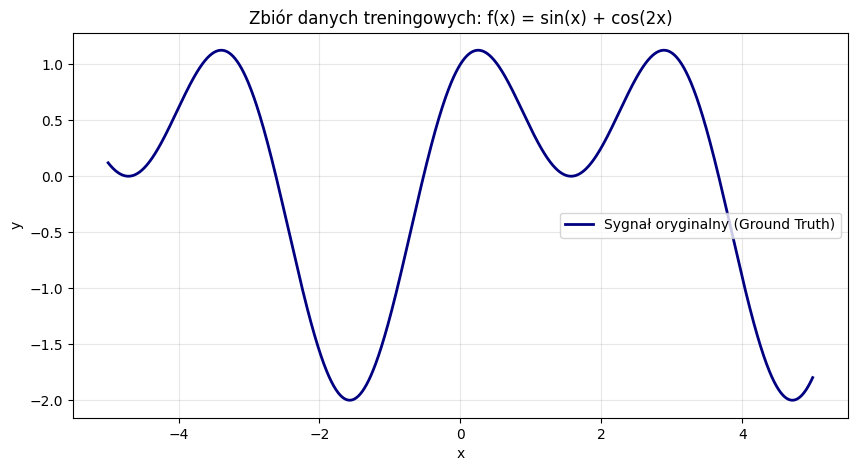

In [2]:
# Parametry globalne
X_MIN, X_MAX = -5, 5
N_SAMPLES = 2000

# Funkcja Ground Truth
def ground_truth(x):
    return np.sin(x) + np.cos(2*x)

# Generowanie zbioru danych
x_range = np.linspace(X_MIN, X_MAX, N_SAMPLES)
y_clean = ground_truth(x_range)

# Wizualizacja danych wzorcowych
plt.figure(figsize=(10, 5))
plt.plot(x_range, y_clean, label='Sygnał oryginalny (Ground Truth)', color='navy', linewidth=2)
plt.title("Zbiór danych treningowych: f(x) = sin(x) + cos(2x)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 3. Proces Dyfuzji (Forward Process)

Proces dyfuzji w przód (Forward Diffusion) polega na stopniowym dodawaniu szumu Gaussa do danych w $T$ krokach.

Wykorzystujemy klasę `DiffusionDataset`, która:
1.  Przyjmuje czyste dane ($x_0$).
2.  Dla każdego przykładu losuje krok czasowy $t$.
3.  Oblicza zaszumioną próbkę $x_t$:
    $$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$
    gdzie $\epsilon \sim \mathcal{N}(0, I)$.

Dzięki temu nie musimy iterować pętli $t$ razy, lecz możemy od razu wylosować stan w dowolnym kroku $t$.

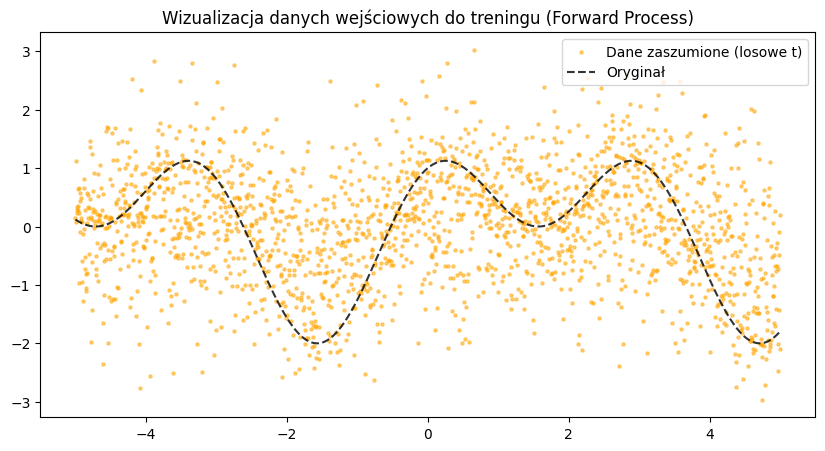

In [3]:
# Parametry dyfuzji
T_STEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

# Harmonogram szumu (Linear Beta Schedule)
betas = torch.linspace(BETA_START, BETA_END, T_STEPS).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

class DiffusionDataset(Dataset):
    def __init__(self, x, y_clean, alphas_cumprod, total_timesteps):
        self.x = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
        self.y0 = torch.tensor(y_clean, dtype=torch.float32).unsqueeze(1).to(device)
        self.alphas_cumprod = alphas_cumprod
        self.total_timesteps = total_timesteps

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        # 1. Pobranie danych
        x_val = self.x[idx]
        y_orig = self.y0[idx]
        
        # 2. Losowanie kroku czasowego t
        t = torch.randint(0, self.total_timesteps, (1,), device=device)
        
        # 3. Pobranie parametrów szumu dla t
        sqrt_alpha_cumprod = torch.sqrt(self.alphas_cumprod[t])
        sqrt_one_minus_alpha_cumprod = torch.sqrt(1 - self.alphas_cumprod[t])
        
        # 4. Generowanie szumu 
        epsilon = torch.randn_like(y_orig)
        
        # 5. Zaszumienie danych
        # y_t = mean + variance * noise
        y_noisy = sqrt_alpha_cumprod * y_orig + sqrt_one_minus_alpha_cumprod * epsilon
        
        return x_val, t.float(), y_noisy, epsilon, y_orig

# Wizualizacja procesu zaszumiania
viz_dataset = DiffusionDataset(x_range, y_clean, alphas_cumprod, T_STEPS)
viz_loader = DataLoader(viz_dataset, batch_size=len(x_range), shuffle=False)
_, _, yt_viz, _, _ = next(iter(viz_loader))

plt.figure(figsize=(10, 5))
plt.scatter(x_range, yt_viz.cpu().numpy(), s=5, alpha=0.5, c='orange', label='Dane zaszumione (losowe t)')
plt.plot(x_range, y_clean, 'k--', label='Oryginał', alpha=0.8)
plt.title("Wizualizacja danych wejściowych do treningu (Forward Process)")
plt.legend()
plt.show()

## 4. Architektura sieci neuronowej (NoisePredictor MLP)

Model `NoisePredictor` to sieć MLP (Multi-Layer Perceptron), której zadaniem jest przewidzenie szumu $\epsilon$ dodanego do obrazu w kroku $t$.

**Elementy architektury:**
1.  **Time Embedding:** Sieć musi wiedzieć, w którym kroku dyfuzji się znajduje. Ponieważ $t$ jest skalarem, mapujemy go na wektor cech (embedding), aby sieć mogła efektywnie wykorzystać tę informację.
2.  **Konkatenacja:** Cechy sygnału wejściowego $x$ oraz zakodowany czas są łączone i przetwarzane przez kolejne warstwy gęste (Linear).

In [4]:
class NoisePredictor(nn.Module):
    def __init__(self, total_timesteps, hidden_dim=256):
        super().__init__()
        self.total_timesteps = total_timesteps
        
        # Moduł kodowania czasu 
        self.time_mlp = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Główna sieć
        self.net = nn.Sequential(
            # Wejście: [wartość_x (1) + embedding_czasu (64)]
            nn.Linear(1 + 64, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            
            nn.Linear(hidden_dim // 2, 1) # Wyjście: Przewidywany szum
        )

    def forward(self, x, t):
        # Normalizacja czasu do zakresu [0, 1] i kodowanie
        t_norm = t / self.total_timesteps
        t_emb = self.time_mlp(t_norm)
        
        # Łączenie wejścia (x) z informacją o czasie
        x_input = torch.cat([x, t_emb], dim=1)
        
        return self.net(x_input)

## 5. Pętla treningowa i optymalizacja

Trenujemy model, aby minimalizował różnicę między szumem rzeczywistym ($\epsilon$), a szumem przewidzianym przez sieć ($\epsilon_\theta(x_t, t)$). Używamy funkcji straty MSE (Mean Squared Error).


[INFO] Rozpoczynanie treningu: 800 epok, Batch size: 128


Trening:   0%|          | 0/800 [00:00<?, ?it/s]

[INFO] Epoka 100/800 | Loss: 0.260796
[INFO] Epoka 200/800 | Loss: 0.238632
[INFO] Epoka 300/800 | Loss: 0.236642
[INFO] Epoka 400/800 | Loss: 0.281160
[INFO] Epoka 500/800 | Loss: 0.248067
[INFO] Epoka 600/800 | Loss: 0.250953
[INFO] Epoka 700/800 | Loss: 0.241857
[INFO] Epoka 800/800 | Loss: 0.274347


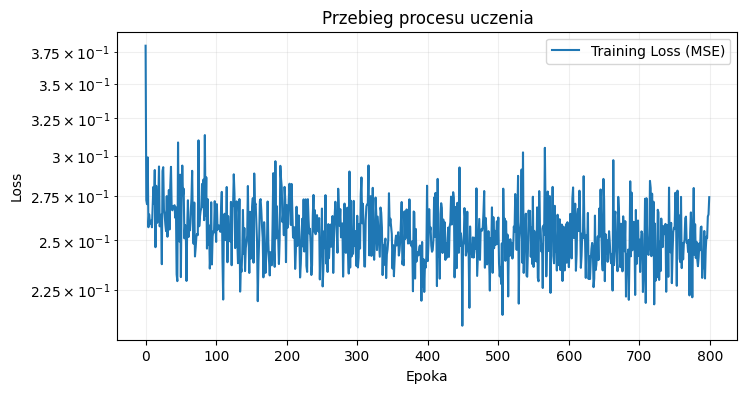

In [5]:
def train_model(model, dataset, epochs, batch_size=64, lr=1e-3):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    loss_history = []
    model.train()
    
    logger.info(f"Rozpoczynanie treningu: {epochs} epok, Batch size: {batch_size}")
    
    for epoch in tqdm(range(epochs), desc="Trening"):
        epoch_loss = 0.0
        
        for x_batch, t_batch, yt_batch, eps_true, _ in dataloader:
            optimizer.zero_grad()
            
            # Predykcja szumu przez model
            # Model otrzymuje: zaszumioną wartość (yt_batch) oraz czas (t_batch)
            eps_pred = model(yt_batch, t_batch)
            
            # Obliczenie straty i aktualizacja wag
            loss = loss_fn(eps_pred, eps_true)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        loss_history.append(avg_loss)
        
        if (epoch + 1) % 100 == 0:
            logger.info(f"Epoka {epoch+1}/{epochs} | Loss: {avg_loss:.6f}")
            
    return loss_history

# Inicjalizacja modelu i uruchomienie treningu
model = NoisePredictor(total_timesteps=T_STEPS).to(device)
dataset_train = DiffusionDataset(x_range, y_clean, alphas_cumprod, T_STEPS)

# Trening
history = train_model(model, dataset_train, epochs=800, batch_size=128)

# Wykres funkcji straty
plt.figure(figsize=(8, 4))
plt.plot(history, label='Training Loss (MSE)')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Przebieg procesu uczenia')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

## 6. Ewaluacja i analiza wyników (Reverse Process)

Po wytrenowaniu modelu sprawdzamy jego skuteczność. Test polega na pobraniu mocno zaszumionych danych (np. z połowy procesu dyfuzji, $t=500$) i próbie ich naprawienia (odszumienia) w jednym kroku.

W pełnym modelu dyfuzyjnym (DDPM) proces ten odbywa się iteracyjnie ($T \to 0$). Tutaj, dla uproszczenia wizualizacji i analizy działania MLP, pokazujemy estymację $x_0$ na podstawie pojedynczej predykcji w zadanym kroku $t$.

Estymata $x_0$ jest wyliczana ze wzoru (przekształcenie wzoru na Forward Process):
$$\hat{x}_0 = \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \cdot \epsilon_\theta(x_t, t)}{\sqrt{\bar{\alpha}_t}}$$

Analiza dla małego szumu (t=100):


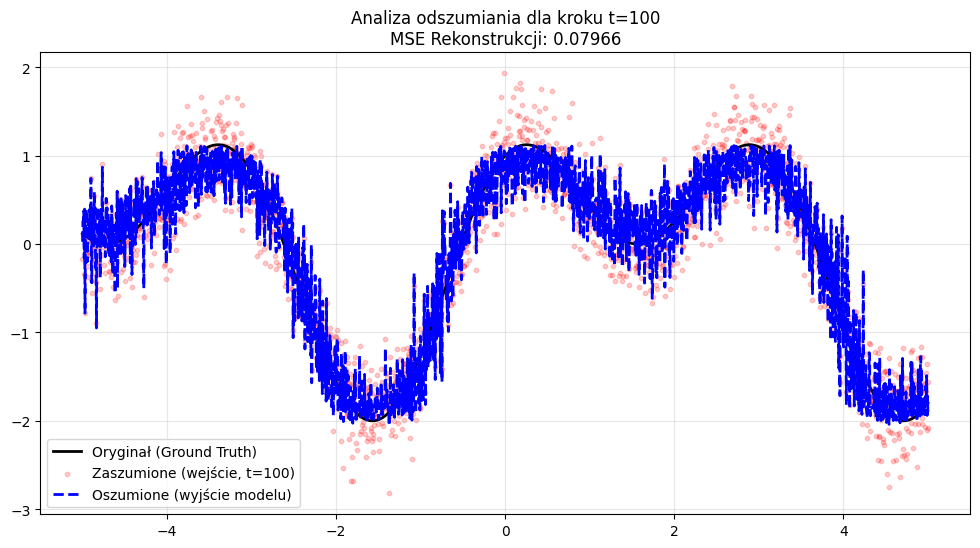


Analiza dla dużego szumu (t=800):


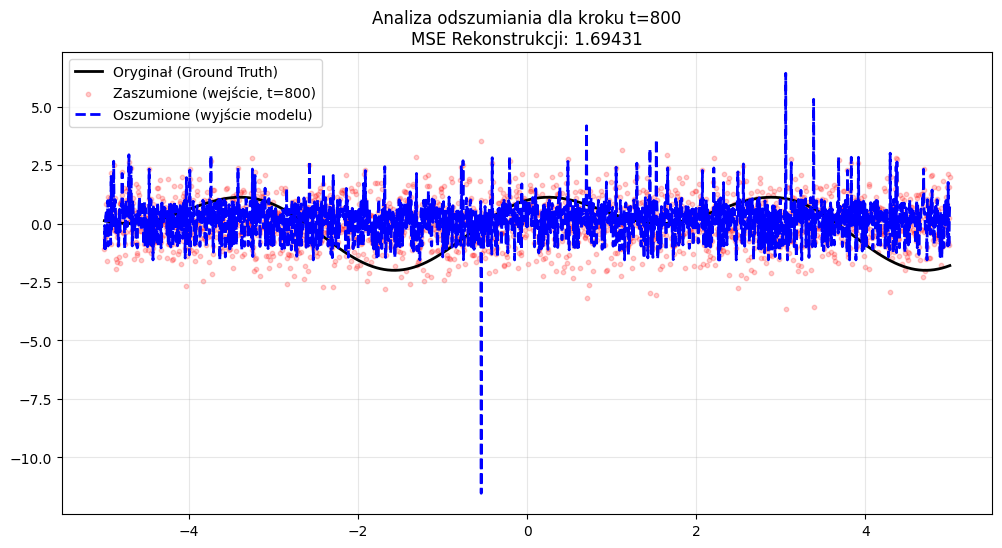

In [7]:
def evaluate_and_plot(model, x_range, y_clean, t_eval_step):
    model.eval()
    
    # 1. Przygotowanie danych dla konkretnego kroku t
    t_idx = t_eval_step - 1
    alpha_cumprod_t = alphas_cumprod[t_idx].item()
    sqrt_alpha = np.sqrt(alpha_cumprod_t)
    sqrt_one_minus_alpha = np.sqrt(1 - alpha_cumprod_t)
    
    # Generowanie zaszumionej próbki ręcznie
    noise = np.random.normal(0, 1, size=y_clean.shape)
    y_noisy = sqrt_alpha * y_clean + sqrt_one_minus_alpha * noise
    
    y_noisy_tensor = torch.tensor(y_noisy, dtype=torch.float32).unsqueeze(1).to(device)
    t_tensor = torch.full((len(y_clean), 1), t_eval_step, dtype=torch.float32).to(device)
    
    # 2. Predykcja szumu przez model
    with torch.no_grad():
        predicted_noise = model(y_noisy_tensor, t_tensor).cpu().numpy().flatten()
    
    # 3. Rekonstrukcja sygnału (Odszumianie)
    y_reconstructed = (y_noisy - sqrt_one_minus_alpha * predicted_noise) / sqrt_alpha
    
    # 4. Obliczenie błędu
    mse_score = mean_squared_error(y_clean, y_reconstructed)
    
    # 5. Wizualizacja
    plt.figure(figsize=(12, 6))
    plt.plot(x_range, y_clean, 'k-', linewidth=2, label='Oryginał (Ground Truth)')
    plt.scatter(x_range, y_noisy, c='red', s=10, alpha=0.2, label=f'Zaszumione (wejście, t={t_eval_step})')
    plt.plot(x_range, y_reconstructed, 'b--', linewidth=2, label='Oszumione (wyjście modelu)')
    
    plt.title(f"Analiza odszumiania dla kroku t={t_eval_step}\nMSE Rekonstrukcji: {mse_score:.5f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

print("Analiza dla małego szumu (t=100):")
evaluate_and_plot(model, x_range, y_clean, t_eval_step=100)

print("\nAnaliza dla dużego szumu (t=800):")
evaluate_and_plot(model, x_range, y_clean, t_eval_step=800)

## 7. Wizualizacja i analiza architektury sieci
Model NoisePredictor nie jest zwykłym perceptronem. Posiada dwie ścieżki wejściowe, które łączą się wewnątrz sieci. 

Poniżej wizualizujemy ten proces, aby zrozumieć, jak informacja o czasie ($t$) wpływa na przetwarzanie sygnału ($x$).

Schemat przepływu danych (Data Flow):
1. **Ścieżka Czasu** (Time Path):
   * Wejście: Skalar $t$ (krok dyfuzji).
   * Przetwarzanie: $t$ jest normalizowane i przepuszczane przez małą podsieć (time_mlp).
   * Celem jest zamiana prostej liczby w bogaty wektor cech (embedding o rozmiarze 64), który pozwala sieci "zrozumieć" kontekst szumu.
2. **Ścieżka Sygnału** (Signal Path):
   * Wejście: Skalar $x$ (zaszumiona wartość).
3. **Fuzja** (Concatenation): Wektor czasu (64) i sygnał (1) są łączone w wektor o długości 65.
4. Główna sieć (Main Net): Połączony wektor przechodzi przez warstwy gęste (Linear), aktywacje (ReLU) i normalizację (BatchNorm), stopniowo redukując wymiarowość, aż do wygenerowania pojedynczej wartości przewidywanego szumu.

In [24]:
TOTAL_TIMESTEPS = 200
model = NoisePredictor(total_timesteps=TOTAL_TIMESTEPS)
model.eval() 

# WIZUALIZACJA TABELARYCZNA (Torchinfo)

try:
    from torchinfo import summary
    print(" Podsumowanie architektury (kształty tensorów) ")
    print(summary(model, input_data=[torch.randn(32, 1), torch.randint(0, 1000, (32, 1))]))
except ImportError:
    print("Zainstaluj 'torchinfo' aby zobaczyć tabelę warstw.")



 Podsumowanie architektury (kształty tensorów) 
Layer (type:depth-idx)                   Output Shape              Param #
NoisePredictor                           [32, 1]                   --
├─Sequential: 1-1                        [32, 64]                  --
│    └─Linear: 2-1                       [32, 64]                  128
│    └─ReLU: 2-2                         [32, 64]                  --
│    └─Linear: 2-3                       [32, 64]                  4,160
│    └─ReLU: 2-4                         [32, 64]                  --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Linear: 2-5                       [32, 256]                 16,896
│    └─ReLU: 2-6                         [32, 256]                 --
│    └─BatchNorm1d: 2-7                  [32, 256]                 512
│    └─Linear: 2-8                       [32, 256]                 65,792
│    └─ReLU: 2-9                         [32, 256]                 --
│    └─BatchNorm1d: 2-10

Wizualizacja (Wczesny etap, t=800):
--- Analiza aktywacji neuronów dla kroku t=800 ---
Wejście x (zaszumione): 0.2837


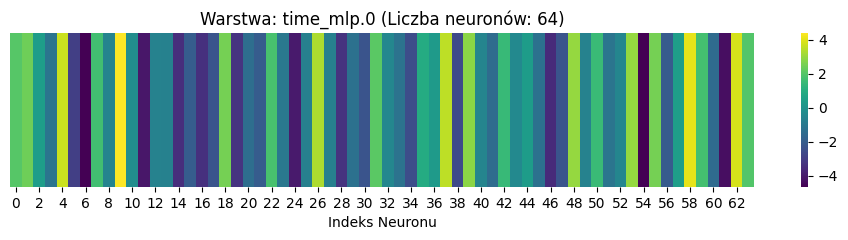

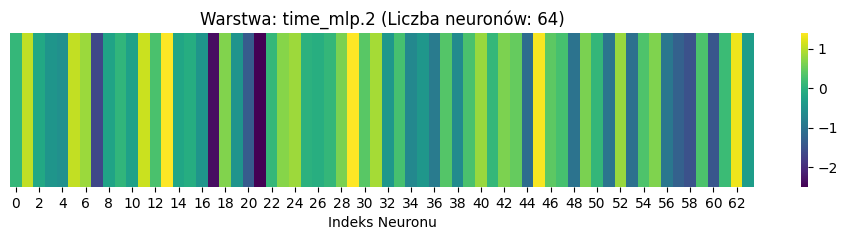

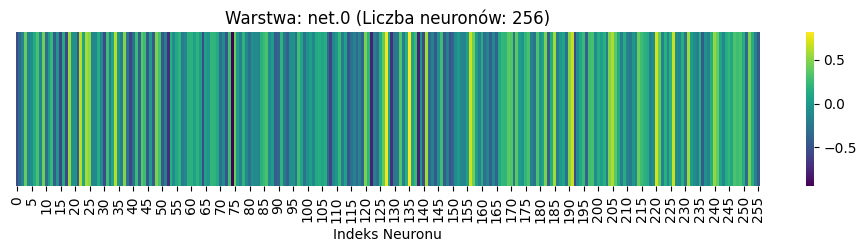

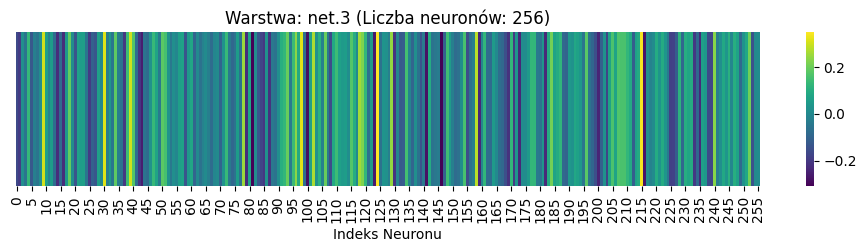


Wizualizacja (Późny etap, t=100):
--- Analiza aktywacji neuronów dla kroku t=100 ---
Wejście x (zaszumione): -0.5374


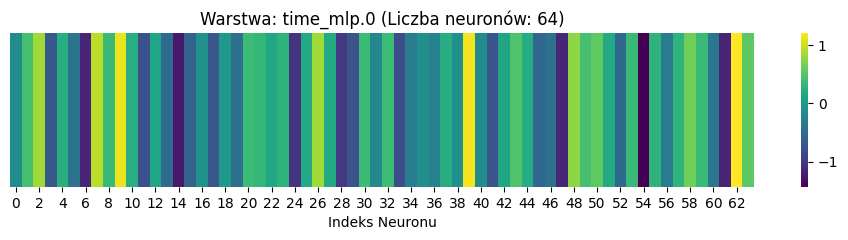

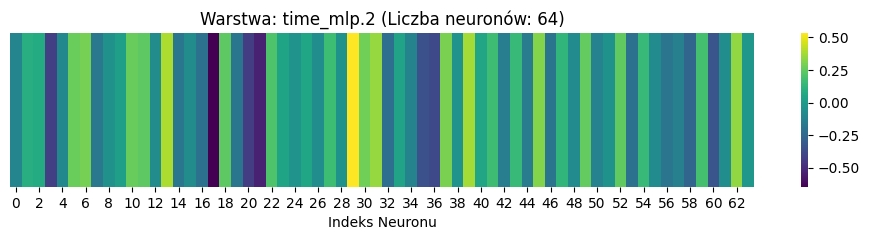

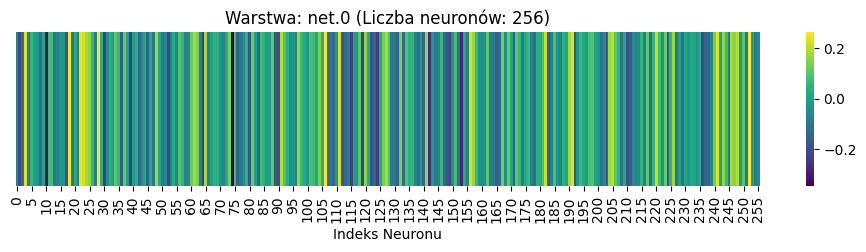

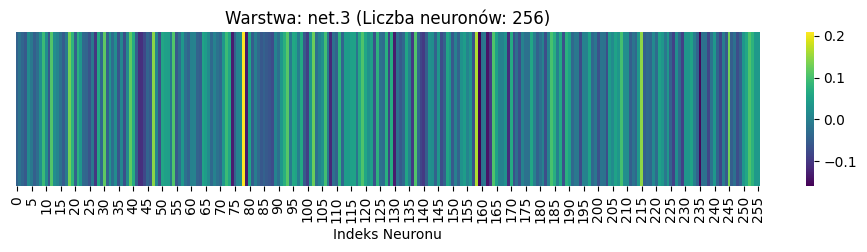

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

def visualize_model_internals(model, x0_input, t_step, layer_limit=4):
    """
    Wizualizuje aktywacje wewnątrz modelu MLP.
    """
    activations = {}
    hooks = []

    def get_activation(name):
        def hook(model, input, output):
            activations[name] = output.detach()
        return hook

    count = 0
    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            hooks.append(layer.register_forward_hook(get_activation(name)))
            count += 1
            if count >= layer_limit:
                break
    
    model.eval()
    
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu") # Fallback
    
    # Konwersja na tensor
    if not torch.is_tensor(x0_input):
        x0_tensor = torch.tensor(x0_input, dtype=torch.float32).to(device)
    else:
        x0_tensor = x0_input.to(device)
        
    if x0_tensor.dim() == 1:
        x0_tensor = x0_tensor.unsqueeze(1)
    
    x_sample = x0_tensor[0:1]
    
    t_tensor = torch.tensor([[t_step]], device=device).float()
    
    noise = torch.randn_like(x_sample)
    x_noisy = 0.5 * x_sample + 0.5 * noise 
    
    with torch.no_grad():
        _ = model(x_noisy, t_tensor)
    
    for h in hooks:
        h.remove()

    print(f"--- Analiza aktywacji neuronów dla kroku t={t_step} ---")
    print(f"Wejście x (zaszumione): {x_noisy.item():.4f}")
    
    for name, act in activations.items():
        if len(act.shape) == 2:
            plt.figure(figsize=(12, 2))
            sns.heatmap(act.cpu().numpy(), cmap="viridis", cbar=True, yticklabels=False)
            plt.title(f"Warstwa: {name} (Liczba neuronów: {act.shape[1]})")
            plt.xlabel("Indeks Neuronu")
            plt.show()

print("Wizualizacja (Wczesny etap, t=800):")
visualize_model_internals(model, y_clean, t_step=800)

print("\nWizualizacja (Późny etap, t=100):")
visualize_model_internals(model, y_clean, t_step=100)

Najważniejszym wnioskiem, jaki powinien płynąć z porównania tych dwóch wykresów (map ciepła), jest to, że **wzorce aktywacji są różne dla $t=800$ i $t=100$**.
Sieć otrzymuje informację o czasie poprzez wektor `t_emb`. Fakt, że dla $t=800$ (duży szum) zapalają się inne neurony lub z inna intensywnością niż dla $t=100$ (mały szum), dowodzi, że **sieć nauczyła się rozróżniać fazy procesu**. Bez tego mechanizmu sieć próbowałaby "uśrednić" swoje działanie dla wszystkich kroków, co dałoby fatalne rezultaty. Tutaj widzimy, że sieć dynamicznie "przełącza się" w zależności od etapu.

Sygnał wejściowy ($0.2837$) jest zdominowany przez szum. Zadaniem sieci jest przewidzenie "grubego", ogólnego kształtu szumu. Aktywacje w tym etapie często są bardziej rozproszone lub angażują neurony odpowiedzialne za wykrywanie globalnych struktur statystycznych rozkładu normalnego.

Sygnał wejściowy ($-0.5374$) jest już bardzo bliski oryginalnej funkcji (sinusoidy), a szum jest niewielki. Zadaniem sieci jest tutaj "precyzyjna korekta" (denoising fine-tuning). Aktywacje mogą być bardziej skupione, wyspecjalizowane w usuwaniu drobnych fluktuacji.


## 8. Dodatkowe wizualizacje

In [27]:
import imageio
T = 400  
BETA_START = 0.0001
BETA_END = 0.02
NOISE_SCALE = 0.1
GIF_FILENAME = "diffusion_noise1.gif"
FRAMES_DIR = "frames"

x_data = np.linspace(-5, 5, 200)
y_clean_data = ground_truth(x_data)

betas = torch.linspace(BETA_START, BETA_END, T)
alphas = 1.0 - betas
alpha_bars = torch.cumprod(alphas, dim=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

os.makedirs(FRAMES_DIR, exist_ok=True)

y_clean_tensor = torch.tensor(y_clean_data, dtype=torch.float32).unsqueeze(1).to(device)

for t in range(1, T + 1):
    alpha_bar_t = alpha_bars[t - 1]

    eps = torch.randn_like(y_clean_tensor) 
    yt = torch.sqrt(alpha_bar_t) * y_clean_tensor + torch.sqrt(1 - alpha_bar_t) * eps
    yt_np = yt.squeeze().cpu().numpy()

    plt.figure(figsize=(8, 5))
    plt.plot(x_data, y_clean_data, label="Czyste dane (y₀)", color="blue")
    plt.scatter(x_data, yt_np, label=f"Zaszumione dane (t={t})", color="orange", s=10)
    plt.title(f"Krok dyfuzji t = {t}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    frame_path = os.path.join(FRAMES_DIR, f"frame_{t:03d}.png")
    plt.savefig(frame_path)
    plt.close()

with imageio.get_writer(GIF_FILENAME, mode="I", duration=0.08) as writer:
    for t in range(1, T + 1):
        frame_path = os.path.join(FRAMES_DIR, f"frame_{t:03d}.png")
        image = imageio.imread(frame_path)
        writer.append_data(image)

print(f"GIF zapisany jako {GIF_FILENAME}")


Używane urządzenie: cuda
GIF zapisany jako diffusion_noise1.gif


## 9. Tuning hiperparametrów i analiza (Grid Search)

W tej sekcji przeprowadzimy poszukiwanie najlepszej konfiguracji. 

Sprawdzimy wpływ czterech  parametrów na jakość odszumiania.
Badane parametry:
* $T$ (Liczba kroków): [200, 500] (Długość procesu)
* $lr$ (Learning Rate): [0.001, 0.0001] (Szybkość uczenia)
* $\beta_{start}$: [0.0001, 0.001] (Początkowy poziom szumu)
* $\beta_{end}$: [0.02, 0.05] (Końcowy poziom szumu)

In [29]:
import itertools
import pandas as pd
import seaborn as sns
import torch
import numpy as np

# 1. Funkcja pomocnicza do generowania harmonogramu szumu (Alphas)
def get_diffusion_schedule(T, b_start, b_end, device=device):
    betas = torch.linspace(b_start, b_end, T).to(device)
    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    return alphas_cumprod

# 2. Definicja siatki parametrów
param_grid = {
    'T_steps': [100, 200],       
    'lr': [1e-3, 1e-4],
    'beta_start': [0.0001, 0.001],
    'beta_end': [0.005,0.02]
}

keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

results = []
SEARCH_EPOCHS = 500  
best_loss = float('inf')
best_config = None
best_model_state = None

print(f"Rozpoczynanie Grid Search. Liczba kombinacji do sprawdzenia: {len(combinations)}")
print("=" * 80)

# 3. Pętla Grid Search
for i, params in enumerate(combinations):
    p_T = params['T_steps']
    p_lr = params['lr']
    p_bs = params['beta_start']
    p_be = params['beta_end']
    
    print(f"[{i+1}/{len(combinations)}] Start: T={p_T}, lr={p_lr}, beta=[{p_bs} - {p_be}] ...")
    
    curr_alphas = get_diffusion_schedule(p_T, p_bs, p_be)
    

    dataset_search = DiffusionDataset(x_range, y_clean, curr_alphas, p_T)
    model_search = NoisePredictor(total_timesteps=p_T).to(device)

    history = train_model(model_search, dataset_search, epochs=SEARCH_EPOCHS, batch_size=128, lr=p_lr)
    

    final_loss = np.mean(history[-15:])
    
    res = params.copy()
    res['final_loss'] = final_loss
    results.append(res)
    
    print(f"    -> Zakończono. Loss: {final_loss:.6f}")
    
    if final_loss < best_loss:
        best_loss = final_loss
        best_config = params
        best_model_state = {k: v.cpu() for k, v in model_search.state_dict().items()}

print("=" * 80)
print(f"Najlepsza konfiguracja: {best_config}")
print(f"Najniższy Loss: {best_loss:.6f}")

[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


Rozpoczynanie Grid Search. Liczba kombinacji do sprawdzenia: 16
[1/16] Start: T=100, lr=0.001, beta=[0.0001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.782873
[INFO] Epoka 200/500 | Loss: 0.761523
[INFO] Epoka 300/500 | Loss: 0.742947
[INFO] Epoka 400/500 | Loss: 0.806202
[INFO] Epoka 500/500 | Loss: 0.788203
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.785674
[2/16] Start: T=100, lr=0.001, beta=[0.0001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.632965
[INFO] Epoka 200/500 | Loss: 0.692289
[INFO] Epoka 300/500 | Loss: 0.659507
[INFO] Epoka 400/500 | Loss: 0.655894
[INFO] Epoka 500/500 | Loss: 0.692921
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.651409
[3/16] Start: T=100, lr=0.001, beta=[0.001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.728809
[INFO] Epoka 200/500 | Loss: 0.745324
[INFO] Epoka 300/500 | Loss: 0.756559
[INFO] Epoka 400/500 | Loss: 0.702737
[INFO] Epoka 500/500 | Loss: 0.704659
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.738238
[4/16] Start: T=100, lr=0.001, beta=[0.001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.627230
[INFO] Epoka 200/500 | Loss: 0.619149
[INFO] Epoka 300/500 | Loss: 0.610840
[INFO] Epoka 400/500 | Loss: 0.642702
[INFO] Epoka 500/500 | Loss: 0.576907
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.638040
[5/16] Start: T=100, lr=0.0001, beta=[0.0001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.818682
[INFO] Epoka 200/500 | Loss: 0.763393
[INFO] Epoka 300/500 | Loss: 0.790034
[INFO] Epoka 400/500 | Loss: 0.722904
[INFO] Epoka 500/500 | Loss: 0.792834
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.754823
[6/16] Start: T=100, lr=0.0001, beta=[0.0001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.636844
[INFO] Epoka 200/500 | Loss: 0.665980
[INFO] Epoka 300/500 | Loss: 0.634913
[INFO] Epoka 400/500 | Loss: 0.626111
[INFO] Epoka 500/500 | Loss: 0.625694
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.639268
[7/16] Start: T=100, lr=0.0001, beta=[0.001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.722099
[INFO] Epoka 200/500 | Loss: 0.742216
[INFO] Epoka 300/500 | Loss: 0.735347
[INFO] Epoka 400/500 | Loss: 0.719747
[INFO] Epoka 500/500 | Loss: 0.728743
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.726787
[8/16] Start: T=100, lr=0.0001, beta=[0.001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.591537
[INFO] Epoka 200/500 | Loss: 0.629556
[INFO] Epoka 300/500 | Loss: 0.627512
[INFO] Epoka 400/500 | Loss: 0.623600
[INFO] Epoka 500/500 | Loss: 0.618309
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.618405
[9/16] Start: T=200, lr=0.001, beta=[0.0001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.733122
[INFO] Epoka 200/500 | Loss: 0.745735
[INFO] Epoka 300/500 | Loss: 0.737671
[INFO] Epoka 400/500 | Loss: 0.748332
[INFO] Epoka 500/500 | Loss: 0.707626
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.735475
[10/16] Start: T=200, lr=0.001, beta=[0.0001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.516120
[INFO] Epoka 200/500 | Loss: 0.503524
[INFO] Epoka 300/500 | Loss: 0.552729
[INFO] Epoka 400/500 | Loss: 0.526880
[INFO] Epoka 500/500 | Loss: 0.517877
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.526161
[11/16] Start: T=200, lr=0.001, beta=[0.001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.654861
[INFO] Epoka 200/500 | Loss: 0.667728
[INFO] Epoka 300/500 | Loss: 0.691936
[INFO] Epoka 400/500 | Loss: 0.668531
[INFO] Epoka 500/500 | Loss: 0.686737
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.693256
[12/16] Start: T=200, lr=0.001, beta=[0.001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.507896
[INFO] Epoka 200/500 | Loss: 0.498923
[INFO] Epoka 300/500 | Loss: 0.533918
[INFO] Epoka 400/500 | Loss: 0.534089
[INFO] Epoka 500/500 | Loss: 0.478789
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.499525
[13/16] Start: T=200, lr=0.0001, beta=[0.0001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.742897
[INFO] Epoka 200/500 | Loss: 0.678453
[INFO] Epoka 300/500 | Loss: 0.648443
[INFO] Epoka 400/500 | Loss: 0.741958
[INFO] Epoka 500/500 | Loss: 0.756643
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.717046
[14/16] Start: T=200, lr=0.0001, beta=[0.0001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.542404
[INFO] Epoka 200/500 | Loss: 0.543725
[INFO] Epoka 300/500 | Loss: 0.515267
[INFO] Epoka 400/500 | Loss: 0.505475
[INFO] Epoka 500/500 | Loss: 0.545781
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.522858
[15/16] Start: T=200, lr=0.0001, beta=[0.001 - 0.005] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.651823
[INFO] Epoka 200/500 | Loss: 0.684069
[INFO] Epoka 300/500 | Loss: 0.684281
[INFO] Epoka 400/500 | Loss: 0.678255
[INFO] Epoka 500/500 | Loss: 0.671882
[INFO] Rozpoczynanie treningu: 500 epok, Batch size: 128


    -> Zakończono. Loss: 0.660314
[16/16] Start: T=200, lr=0.0001, beta=[0.001 - 0.02] ...


Trening:   0%|          | 0/500 [00:00<?, ?it/s]

[INFO] Epoka 100/500 | Loss: 0.499693
[INFO] Epoka 200/500 | Loss: 0.495146
[INFO] Epoka 300/500 | Loss: 0.486881
[INFO] Epoka 400/500 | Loss: 0.501299
[INFO] Epoka 500/500 | Loss: 0.464379


    -> Zakończono. Loss: 0.498684
Najlepsza konfiguracja: {'T_steps': 200, 'lr': 0.0001, 'beta_start': 0.001, 'beta_end': 0.02}
Najniższy Loss: 0.498684



=== Top 5 Najlepszych Konfiguracji ===
 T_steps     lr  beta_start  beta_end  final_loss
     200 0.0001      0.0010      0.02    0.498684
     200 0.0010      0.0010      0.02    0.499525
     200 0.0001      0.0001      0.02    0.522858
     200 0.0010      0.0001      0.02    0.526161
     100 0.0001      0.0010      0.02    0.618405


[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


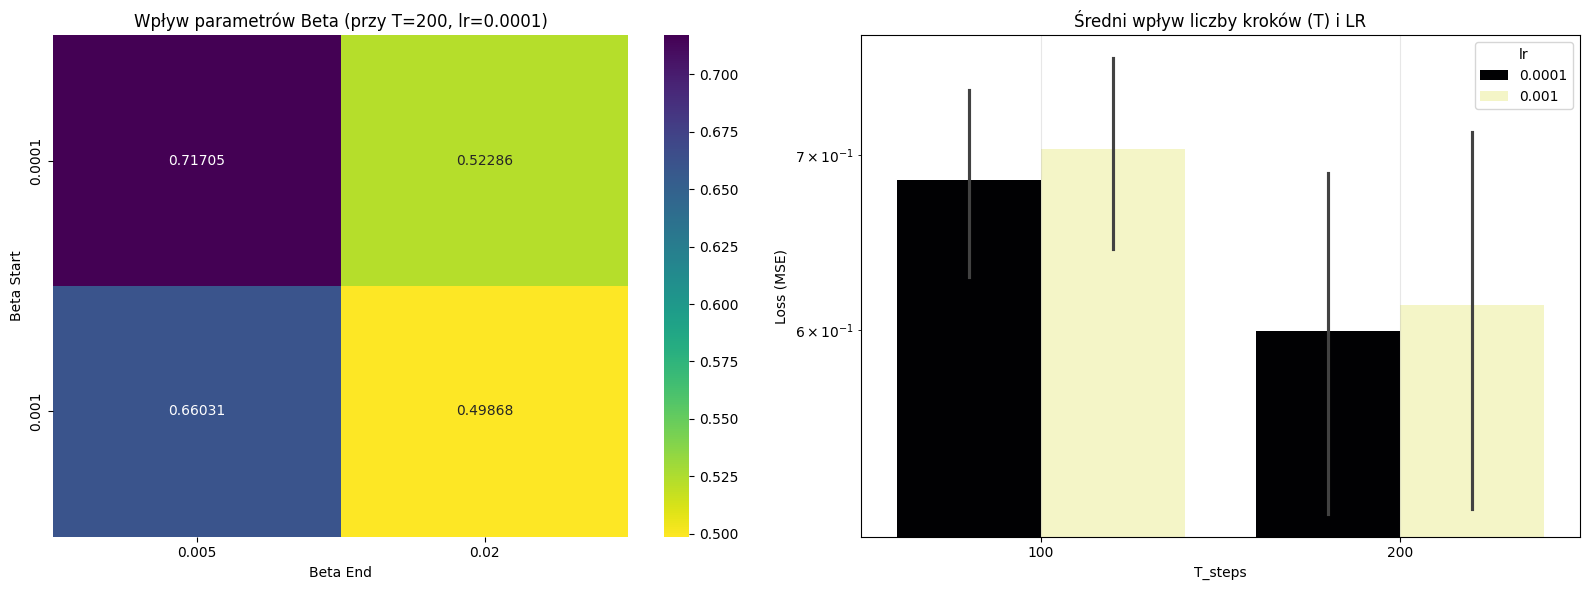


=== Ewaluacja Najlepszego Modelu ({'T_steps': 200, 'lr': 0.0001, 'beta_start': 0.001, 'beta_end': 0.02}) ===


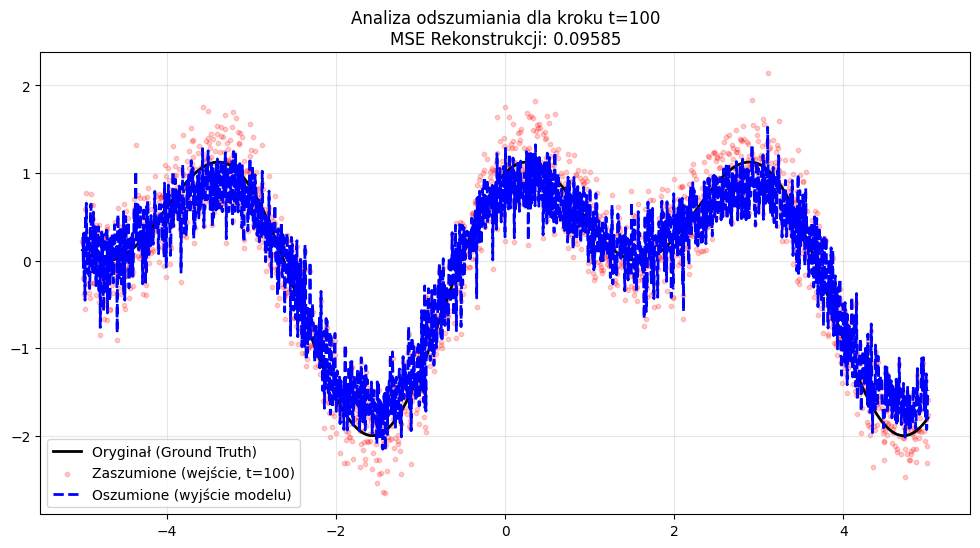

In [30]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='final_loss')

print("\n=== Top 5 Najlepszych Konfiguracji ===")
print(df_results.head(5).to_string(index=False))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Wykres 1: Wpływ Beta Start i End na Loss (dla najlepszego T i lr)
best_T = best_config['T_steps']
best_lr = best_config['lr']
subset = df_results[(df_results['T_steps'] == best_T) & (df_results['lr'] == best_lr)]

sns.heatmap(
    subset.pivot(index='beta_start', columns='beta_end', values='final_loss'),
    annot=True, fmt=".5f", cmap="viridis_r", ax=axes[0]
)
axes[0].set_title(f"Wpływ parametrów Beta (przy T={best_T}, lr={best_lr})")
axes[0].set_ylabel("Beta Start")
axes[0].set_xlabel("Beta End")

# Wykres 2: Ogólny wpływ T i LR (uśredniony po betach)
sns.barplot(data=df_results, x='T_steps', y='final_loss', hue='lr', ax=axes[1], palette='magma')
axes[1].set_title("Średni wpływ liczby kroków (T) i LR")
axes[1].set_ylabel("Loss (MSE)")
axes[1].set_yscale("log")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== Ewaluacja Najlepszego Modelu ({best_config}) ===")

# Odtworzenie modelu
final_T = best_config['T_steps']
final_alphas = get_diffusion_schedule(final_T, best_config['beta_start'], best_config['beta_end'])

best_model = NoisePredictor(total_timesteps=final_T).to(device)
best_model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

# Test dla środkowego etapu dyfuzji
evaluate_and_plot(best_model, x_range, y_clean, t_eval_step=int(final_T / 2))